In [1]:
from scGeneFit import *
%matplotlib inline
import scipy.io as sio

# CITEseq example

In [2]:
#load data from file
a = sio.loadmat("./data/CITEseq.mat")
data= a['G'].T
N,d=data.shape
#transformation from integer entries 
data=np.log(data+np.ones(data.shape))
for i in range(N):
    data[i,:]=data[i,:]/np.linalg.norm(data[i,:])

#load labels from file
a = sio.loadmat("./data/CITEseq-labels.mat")
l_aux = a['labels']
labels = np.array([i for [i] in l_aux])

#load names from file
a = sio.loadmat("./data/CITEseq_names.mat")
names=[a['citeseq_names'][i][0][0] for i in range(N)]

## Use of scGeneFit (pairwise distance constraints)

Solving a linear program with 500 variables and 5000 constraints
Time elapsed: 172.62960600852966 seconds
Computing TSNE embedding
Elapsed time: 229.7222011089325 seconds


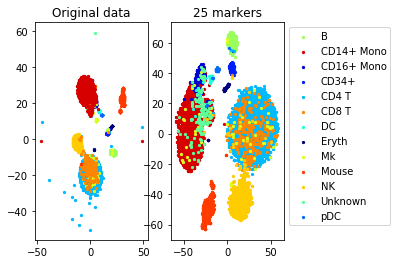

In [3]:
num_markers=25
sampling_rate=0.1 #use 10 percent of the data to generate constraints
n_neighbors=3 #3 constraints per point
epsilon=10 #Delta is 10*norm of the smallest constraint
max_constraints=5000 #use at most 5000 constraints (for efficiency)
use_centers=False #constraints given by pairwise distances

markers= get_markers(data, labels, num_markers, sampling_rate,  n_neighbors, epsilon, max_constraints, use_centers)
a=plot_marker_selection(data, markers, names)

## Use of scGeneFit (center based constraints)

Solving a linear program with 500 variables and 5000 constraints
Time elapsed: 200.31908583641052 seconds
Computing TSNE embedding
Elapsed time: 237.68391394615173 seconds


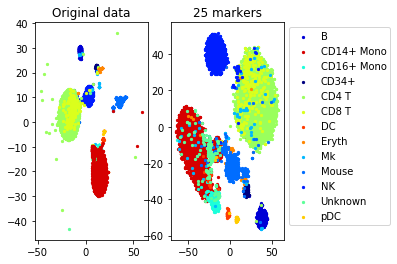

In [4]:
num_markers=25
sampling_rate=0.1 #use 10 percent of the data to generate constraints
n_neighbors=0 #neighbors are not used for the center constraints 
epsilon=10 #Delta is 10*norm of the smallest constraint
max_constraints=5000 #use at most 5000 constraints (for efficiency)
use_centers=True #constraints given by pairwise distances

markers= get_markers(data, labels, num_markers, sampling_rate,  n_neighbors, epsilon, max_constraints, use_centers)
a=plot_marker_selection(data, markers, names)

## One vs all markers

Computing TSNE embedding
Elapsed time: 223.56700992584229 seconds


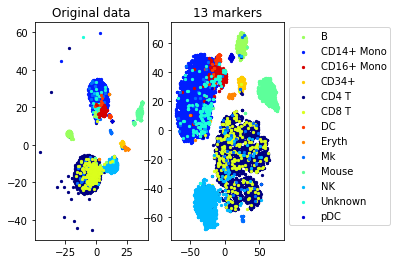

In [4]:
markers2=one_vs_all_selection(data,labels)
a=plot_marker_selection(data, markers2, names)


# Zeisel example

In [3]:
#load data from file
a = sio.loadmat("./data/zeisel_data.mat")
data= a['zeisel_data'].T
N,d=data.shape

#load labels (first level of the hierarchy) from file
a = sio.loadmat("./data/zeisel_labels1.mat")
l_aux = a['zeisel_labels1']
l_0=[l_aux[i][0] for i in range(l_aux.shape[0])]
#load labels (second level of the hierarchy) from file
a = sio.loadmat("./data/zeisel_labels2.mat")
l_aux = a['zeisel_labels2']
l_1=[l_aux[i][0] for i in range(l_aux.shape[0])]
#construct an array with hierarchy labels
labels=np.array([l_0, l_1])

# load names from file 
a = sio.loadmat("./data/zeisel_names.mat")
names=[a['zeisel_names'][i][0][0] for i in range(N)]


## Use of scGeneFit (pairwise distance constraints)

Solving a linear program with 4000 variables and 600 constraints
Time elapsed: 129.8402760028839 seconds
Computing TSNE embedding
Elapsed time: 115.67911911010742 seconds


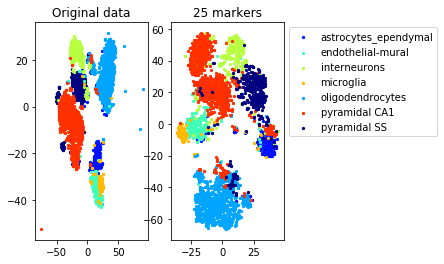

In [5]:
num_markers=25
sampling_rate=0.05 #use 5 percent of the data to generate constraints
n_neighbors=3 #3 constraints per point
epsilon=10 #Delta is 10*norm of the smallest constraint
max_constraints=600 #use at most 600 constraints (for efficiency)
use_centers=False #constraints given by pairwise distances

markers = get_markers_hierarchy(data, labels, num_markers, sampling_rate,  n_neighbors, epsilon, max_constraints, use_centers)
a=plot_marker_selection(data, markers, names)

## Use of scGeneFit (center based constraints)

Solving a linear program with 4000 variables and 600 constraints
Time elapsed: 198.22960305213928 seconds
Computing TSNE embedding
Elapsed time: 94.75522494316101 seconds


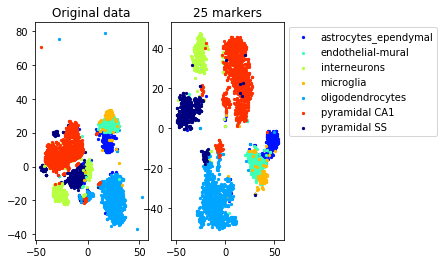

In [9]:
num_markers=25
sampling_rate=0.05 #use 5 percent of the data to generate constraints
n_neighbors=0 #neighbors are not used for the center constraints
epsilon=10 #Delta is 10*norm of the smallest constraint
max_constraints=600 #use at most 600 constraints (for efficiency)
use_centers=True #constraints given by pairwise distances

markers = get_markers_hierarchy(data, labels, num_markers, sampling_rate,  n_neighbors, epsilon, max_constraints, use_centers)
a=plot_marker_selection(data, markers, names)

### Example from second level of the hierarchy

In [17]:
# load names from file 
a = sio.loadmat("./data/zeisel_names.mat")
names2=[a['zeisel_names'][i][1][0] for i in range(N)]

Computing TSNE embedding
Elapsed time: 4.771377801895142 seconds
Computing TSNE embedding
Elapsed time: 1.959817886352539 seconds
Computing TSNE embedding
Elapsed time: 13.536450862884521 seconds
Computing TSNE embedding
Elapsed time: 2.0456972122192383 seconds
Computing TSNE embedding
Elapsed time: 2.846796989440918 seconds
Computing TSNE embedding
Elapsed time: 0.7185342311859131 seconds
Computing TSNE embedding
Elapsed time: 16.893723964691162 seconds


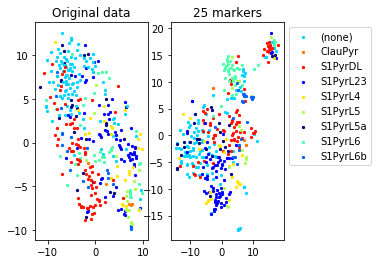

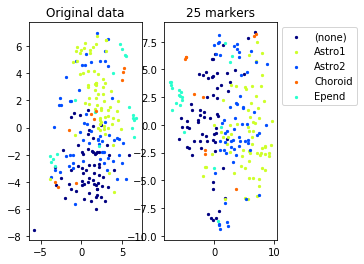

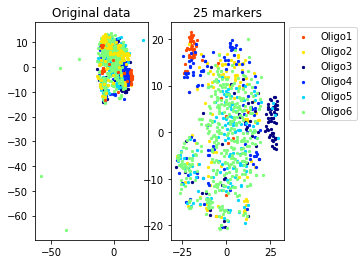

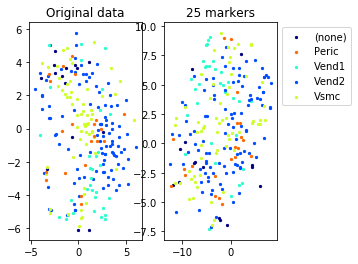

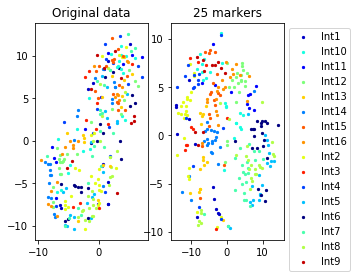

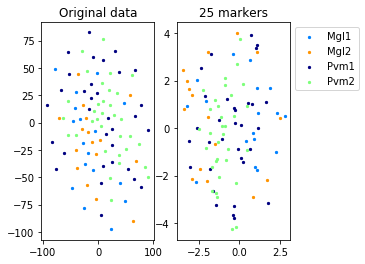

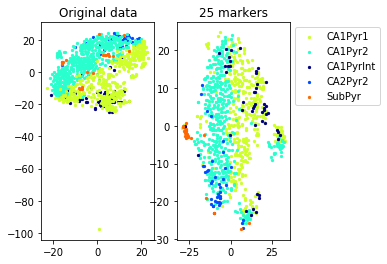

In [33]:
for name in set(names):
    idx=[s for s in range(len(names)) if names[s]==name]
    aux=plot_marker_selection(data[idx], markers, [names2[s] for s in idx])